### Description
This code is used to create plots from CSV files downloaded from the MIDAS history page. Key features include an outlier threshold and adaptability to read from a variety of datasets and generate overlays.

In [31]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("DL_rates_08_07.csv", sep=",")
  # Adjust sep if needed
df.columns = df.columns.str.strip()
print(df.columns.tolist())

# Time column
time = df["Time"].to_numpy()

# Extract each GPIO column as an individual array
gpio_0 = df[df.columns[1]].to_numpy()
gpio_1 = df[df.columns[2]].to_numpy()
gpio_2 = df[df.columns[3]].to_numpy()
gpio_3 = df[df.columns[4]].to_numpy()


['Time', 'cb02/CBR2:gpio_0 CBR2', 'cb02/CBR2:gpio_1 CBR2', 'cb02/CBR2:gpio_2 CBR2', 'cb02/CBR2:gpio_3 CBR2']


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.optimize import curve_fit, minimize
from scipy.signal import fftconvolve
import numpy as np
plt.rcParams.update({
    'font.size': 14,          # Global default font size
    'axes.titlesize': 14,     # Title font size
    'axes.labelsize': 14,     # Axis label font size
    'xtick.labelsize': 14,    # X tick size
    'ytick.labelsize': 14,    # Y tick size
    'legend.fontsize': 12,    # Legend font size
})

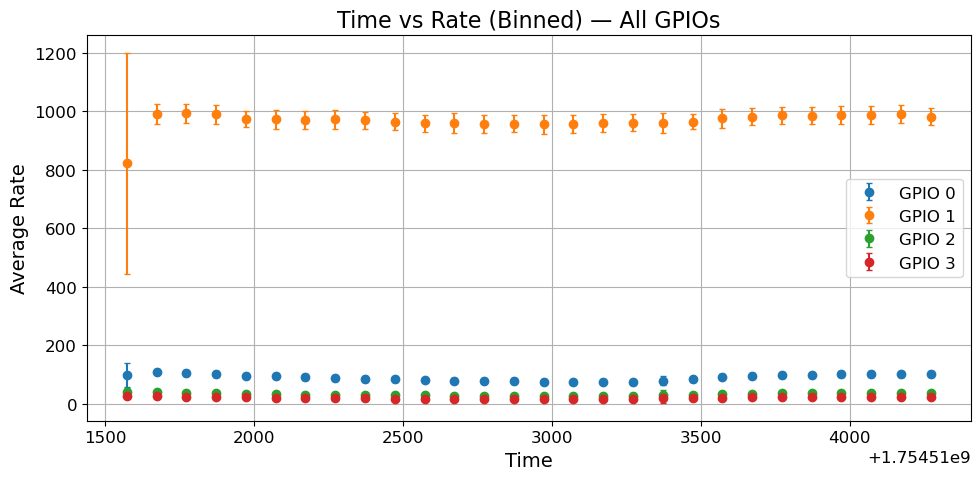

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
bin_width = 100
start_time = 1754511524

# Prepare GPIO data list
gpio_data = [
    (gpio_0, "GPIO 0"),
    (gpio_1, "GPIO 1"),
    (gpio_2, "GPIO 2"),
    (gpio_3, "GPIO 3"),
]

plt.figure(figsize=(10, 5))

# Loop through each GPIO array
for gpio_array, label in gpio_data:
    # Filter based on start time
    mask = time >= start_time
    time_filtered = time[mask]
    data_filtered = gpio_array[mask]

    # Make sure we can bin evenly
    n_points = len(data_filtered)
    n_bins = n_points // bin_width
    trimmed_len = n_bins * bin_width

    if trimmed_len == 0:
        print(f"⚠️ Not enough data after start_time for {label}")
        continue

    # Reshape for binning
    time_binned = time_filtered[:trimmed_len].reshape(n_bins, bin_width)
    data_binned = data_filtered[:trimmed_len].reshape(n_bins, bin_width)

    # Bin-wise stats
    time_avg = time_binned.mean(axis=1)
    rate_avg = data_binned.mean(axis=1)
    rate_std = data_binned.std(axis=1)

    # Plot with error bars
    plt.errorbar(time_avg, rate_avg, yerr=rate_std, fmt='o', capsize=2, label=label)

# Final plot settings
plt.title("Time vs Rate (Binned) — All GPIOs")
plt.xlabel("Time")
plt.ylabel("Average Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


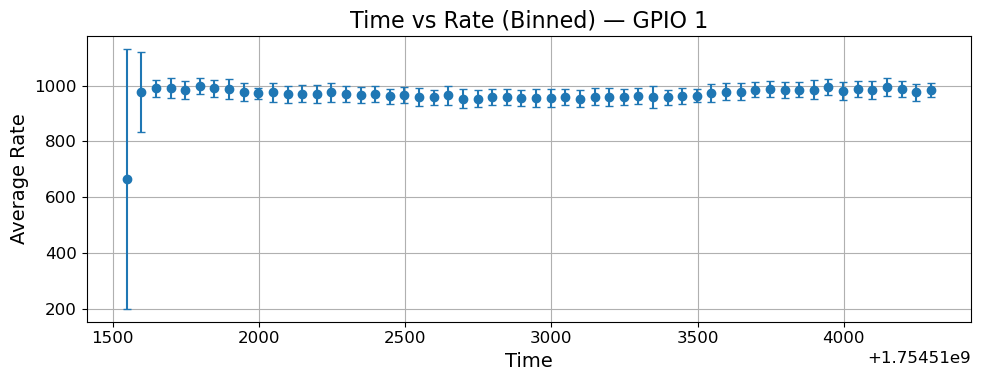

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
bin_width = 50
start_time = 1754511524
label = "GPIO 1"

# Filter by time
mask = time >= start_time
time_filtered = time[mask]
data_filtered = gpio_1[mask]

# Trim to match binning
n_points = len(data_filtered)
n_bins = n_points // bin_width
trimmed_len = n_bins * bin_width

# Skip if not enough data
if trimmed_len == 0:
    print(f"⚠️ Not enough data for {label} after {start_time}")
else:
    time_binned = time_filtered[:trimmed_len].reshape(n_bins, bin_width)
    data_binned = data_filtered[:trimmed_len].reshape(n_bins, bin_width)

    # Compute stats
    time_avg = time_binned.mean(axis=1)
    rate_avg = data_binned.mean(axis=1)
    rate_std = data_binned.std(axis=1)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.errorbar(time_avg, rate_avg, yerr=rate_std, fmt='o', capsize=3, label=label)
    plt.title(f"Time vs Rate (Binned) — {label}")
    plt.xlabel("Time")
    plt.ylabel("Average Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


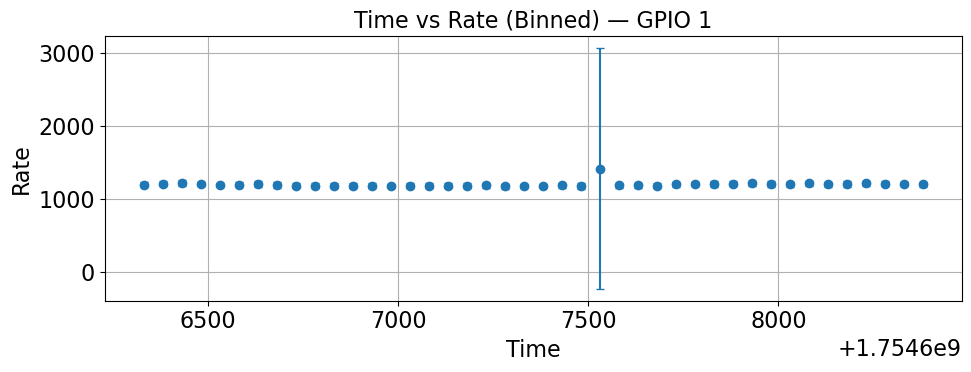

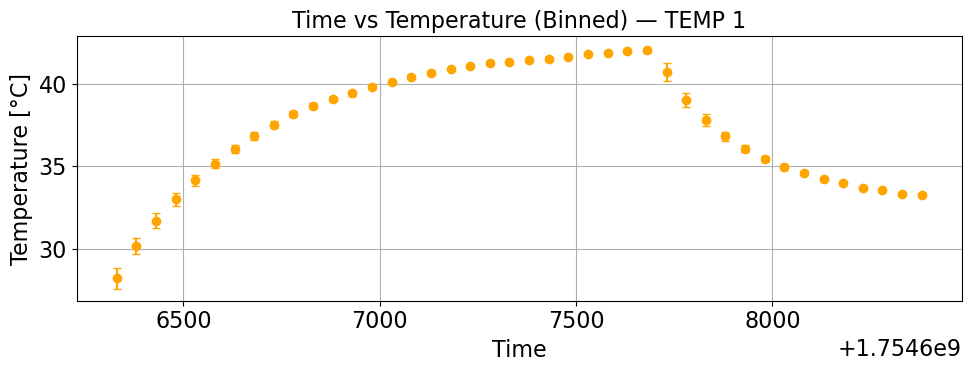

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Load GPIO Rate Data ====
rate_df = pd.read_csv("DL_RATES_80MV.csv", sep=",")
rate_df.columns = rate_df.columns.str.strip()
time_rate = rate_df["Time"].to_numpy()
gpio_1 = rate_df["cb02/CBR2:gpio_1 CBR2"].to_numpy()

# ==== Load TEMP Data ====
temp_df = pd.read_csv("DL_TEMP_80MV.csv", sep=",")
temp_df.columns = temp_df.columns.str.strip()
time_temp = temp_df["Time"].to_numpy()
temp_1 = temp_df["dldb/temp:temp[1]"].to_numpy()

# ==== Filter to match start time ====
start_time = 1754511574
bin_width = 50

# Filter both datasets by time
mask_rate = time_rate >= start_time
mask_temp = time_temp >= start_time

time_rate_filtered = time_rate[mask_rate]
gpio_1_filtered = gpio_1[mask_rate]

time_temp_filtered = time_temp[mask_temp]
temp_1_filtered = temp_1[mask_temp]

# Ensure equal length (in bins)
n_points = min(len(gpio_1_filtered), len(temp_1_filtered))
n_bins = n_points // bin_width
trimmed_len = n_bins * bin_width

# Trim and reshape
gpio_1_binned = gpio_1_filtered[:trimmed_len].reshape(n_bins, bin_width)
time_binned = time_rate_filtered[:trimmed_len].reshape(n_bins, bin_width)
temp_1_binned = temp_1_filtered[:trimmed_len].reshape(n_bins, bin_width)

# Compute stats
time_avg = time_binned.mean(axis=1)

rate_avg = gpio_1_binned.mean(axis=1)
rate_std = gpio_1_binned.std(axis=1)

temp_avg = temp_1_binned.mean(axis=1)
temp_std = temp_1_binned.std(axis=1)

# ==== Plot GPIO 1 Rate ====
plt.figure(figsize=(10, 4))
plt.errorbar(time_avg, rate_avg, yerr=rate_std, fmt='o', capsize=3, label="GPIO 1 Rate")
plt.title("Time vs Rate (Binned) — GPIO 1")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Plot TEMP 1 ====
plt.figure(figsize=(10, 4))
plt.errorbar(time_avg, temp_avg, yerr=temp_std, fmt='o', capsize=3, color='orange', label="Temp 1")
plt.title("Time vs Temperature (Binned) — TEMP 1")
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.tight_layout()
plt.show()


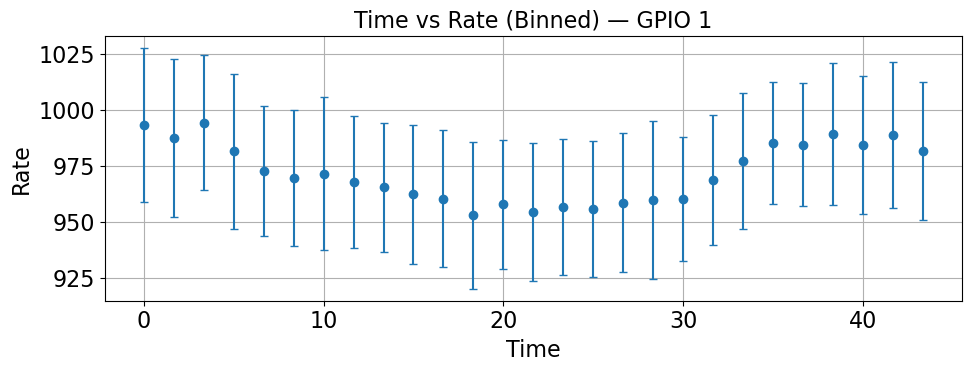

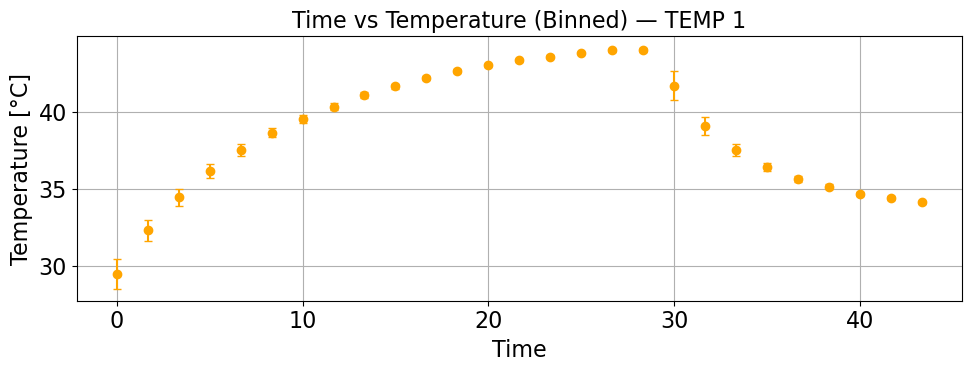

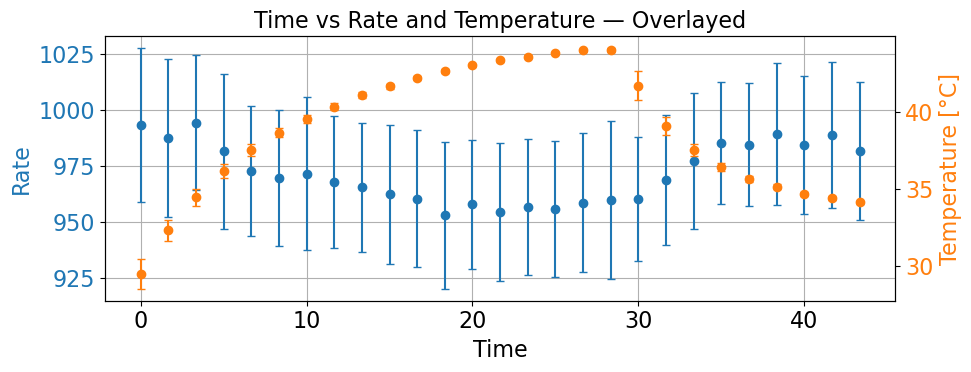

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Load GPIO Rate Data ====
rate_df = pd.read_csv("DL_RATES_80MV.csv", sep=",")
rate_df.columns = rate_df.columns.str.strip()
time_rate = rate_df["Time"].to_numpy()
gpio_1 = rate_df["cb02/CBR2:gpio_1 CBR2"].to_numpy()

# ==== Load TEMP Data ====
temp_df = pd.read_csv("DL_TEMP_80MV.csv", sep=",")
temp_df.columns = temp_df.columns.str.strip()
time_temp = temp_df["Time"].to_numpy()
temp_1 = temp_df["dldb/temp:temp[1]"].to_numpy()

# ==== Filter to match start time ====
start_time = 1754511574
bin_width = 10

# Filter both datasets by time
mask_rate = time_rate >= start_time
mask_temp = time_temp >= start_time

time_rate_filtered = time_rate[mask_rate]
gpio_1_filtered = gpio_1[mask_rate]

time_temp_filtered = time_temp[mask_temp]
temp_1_filtered = temp_1[mask_temp]

# ==== Match lengths ====
n_points = min(len(gpio_1_filtered), len(temp_1_filtered))
n_bins = n_points // bin_width
trimmed_len = n_bins * bin_width

# ==== Bin and reshape ====
time_binned = time_rate_filtered[:trimmed_len].reshape(n_bins, bin_width)
gpio_1_binned = gpio_1_filtered[:trimmed_len].reshape(n_bins, bin_width)
temp_1_binned = temp_1_filtered[:trimmed_len].reshape(n_bins, bin_width)

# ==== Compute stats ====
time_avg = time_binned.mean(axis=1)
time_avg = (time_avg - time_avg[0]) / 60  # Convert to minutes since start

rate_avg = gpio_1_binned.mean(axis=1)
rate_std = gpio_1_binned.std(axis=1)

temp_avg = temp_1_binned.mean(axis=1)
temp_std = temp_1_binned.std(axis=1)

# ==== Plot 1: GPIO 1 Rate ====
plt.figure(figsize=(10, 4))
plt.errorbar(time_avg, rate_avg, yerr=rate_std, fmt='o', capsize=3, label="GPIO 1 Rate")
plt.title("Time vs Rate (Binned) — GPIO 1")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Plot 2: TEMP 1 ====
plt.figure(figsize=(10, 4))
plt.errorbar(time_avg, temp_avg, yerr=temp_std, fmt='o', capsize=3, color='orange', label="TEMP 1")
plt.title("Time vs Temperature (Binned) — TEMP 1")
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Plot 3: Overlayed on Dual Axes ====
fig, ax1 = plt.subplots(figsize=(10, 4))

# Left y-axis: Rate
ax1.errorbar(time_avg, rate_avg, yerr=rate_std, fmt='o', capsize=3, color='tab:blue', label="GPIO 1 Rate")
ax1.set_xlabel("Time")
ax1.set_ylabel("Rate", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Right y-axis: Temperature
ax2 = ax1.twinx()
ax2.errorbar(time_avg, temp_avg, yerr=temp_std, fmt='o', capsize=3, color='tab:orange', label="TEMP 1")
ax2.set_ylabel("Temperature [°C]", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and layout
plt.title("Time vs Rate and Temperature — Overlayed")
fig.tight_layout()
plt.show()


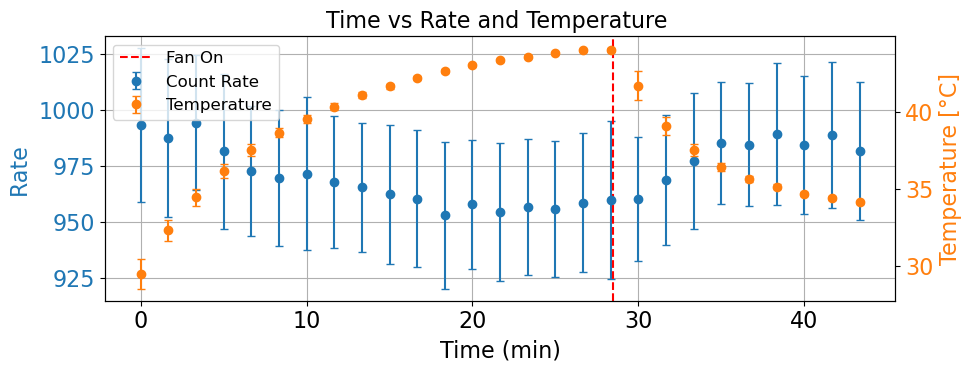

In [25]:
# Time where fan is turned on
fan_on_time = time_avg[0] +28.5

# ==== Plot 3: Overlayed on Dual Axes ====
fig, ax1 = plt.subplots(figsize=(10, 4))

# Left y-axis: Rate
ax1.errorbar(time_avg, rate_avg, yerr=rate_std, fmt='o', capsize=3, color='tab:blue', label="Count Rate")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Rate ", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)
ax1.axvline(fan_on_time, color='red', linestyle='--', label='Fan On')

# Right y-axis: Temperature
ax2 = ax1.twinx()
ax2.errorbar(time_avg, temp_avg, yerr=temp_std, fmt='o', capsize=3, color='tab:orange', label="Temperature")
ax2.set_ylabel("Temperature [°C]", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Title and layout
plt.title("Time vs Rate and Temperature ")
fig.tight_layout()
plt.show()


In [29]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(rate_avg, temp_avg)
print(f"Spearman correlation: {rho:.3f}, p={p_value:.3g}")


Spearman correlation: -0.937, p=7.02e-13


In [30]:
import numpy as np
corr_coeff = np.corrcoef(rate_avg, temp_avg)[0, 1]
print(f"Pearson correlation: {corr_coeff:.3f}")


Pearson correlation: -0.956


2130


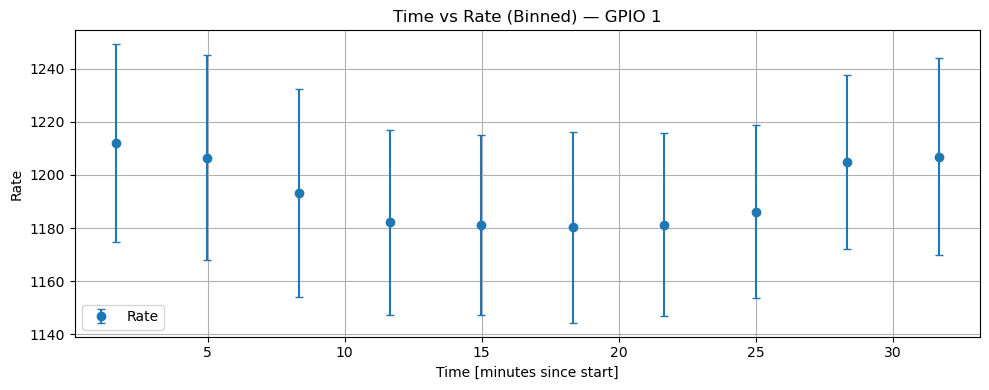

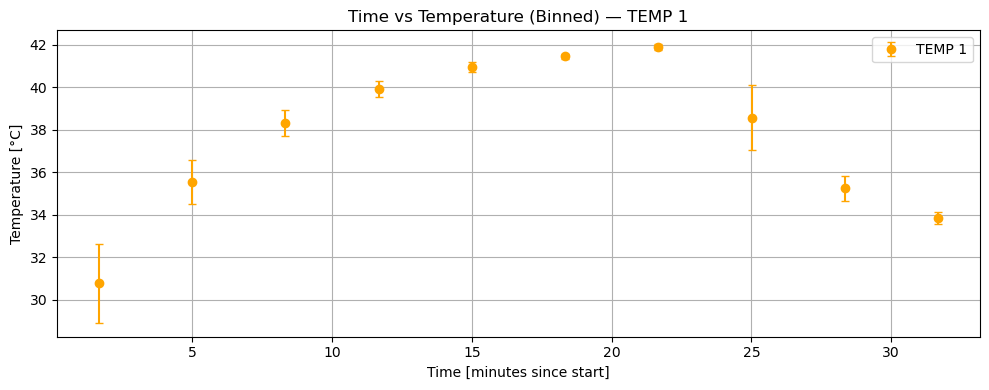

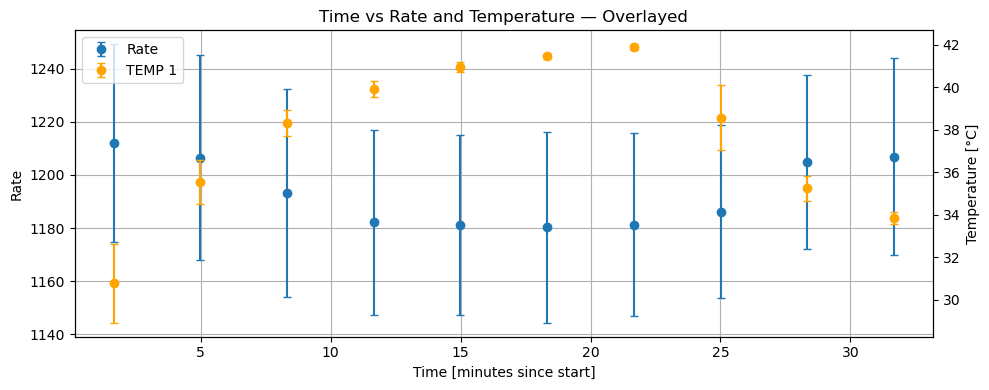

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========================
# Parameters you can edit
# ========================
bin_width = 200
# number of samples per bin
cut_start_min = 0          # trim this many minutes from the beginning
cut_end_min = 0.0               # trim this many minutes from the end
rate_csv = "DL_rates_08_07.2.csv"
temp_csv = "DL_TEMP_08_07.csv"
rate_col = "cb02/CBR2:gpio_1 CBR2"     # GPIO 1
temp_col = "dldb/temp:temp[1]"         # TEMP 1

# ==== Load data ====
rate_df = pd.read_csv(rate_csv, sep=",")
rate_df.columns = rate_df.columns.str.strip()
time_rate = rate_df["Time"].to_numpy()
rate_vals = rate_df[rate_col].to_numpy()

temp_df = pd.read_csv(temp_csv, sep=",")
temp_df.columns = temp_df.columns.str.strip()
time_temp = temp_df["Time"].to_numpy()
temp_vals = temp_df[temp_col].to_numpy()

# ==== Build a common time window ====
# Use the overlapping time range shared by both files
ref_start = max(time_rate.min(), time_temp.min())
ref_end   = min(time_rate.max(), time_temp.max())

# Apply trims in minutes at both ends
window_start = ref_start + cut_start_min * 60.0
window_end   = ref_end   - cut_end_min   * 60.0

if window_end <= window_start:
    raise ValueError("Trimmed window is empty. Reduce cut_start_min or cut_end_min.")

# Filter both datasets into the same window
mask_rate = (time_rate >= window_start) & (time_rate <= window_end)
mask_temp = (time_temp >= window_start) & (time_temp <= window_end)

time_rate_f = time_rate[mask_rate]
rate_f      = rate_vals[mask_rate]

time_temp_f = time_temp[mask_temp]
temp_f      = temp_vals[mask_temp]
# ==== Outlier removal ====
# Define threshold for extreme rate values
rate_threshold = 1e4  # example: remove anything above 100,000

# Build mask to remove outliers
outlier_mask = rate_f <= rate_threshold

# Apply to both time and rate arrays
time_rate_f = time_rate_f[outlier_mask]
rate_f      = rate_f[outlier_mask]

# Also ensure TEMP is trimmed to match new length later


# Make lengths match by truncating to the shorter series
n_points = min(len(rate_f), len(temp_f))
time_rate_f = time_rate_f[:n_points]
rate_f      = rate_f[:n_points]
time_temp_f = time_temp_f[:n_points]
temp_f      = temp_f[:n_points]
print(n_points)
# ==== Bin both series with the same binning ====
n_bins = n_points // bin_width
trimmed_len = n_bins * bin_width
if trimmed_len == 0:
    raise ValueError("Not enough points for at least one bin. Reduce bin_width or trims.")

time_binned = time_rate_f[:trimmed_len].reshape(n_bins, bin_width)  # use rate time for x
rate_binned = rate_f[:trimmed_len].reshape(n_bins, bin_width)
temp_binned = temp_f[:trimmed_len].reshape(n_bins, bin_width)

# ==== Stats per bin ====
time_avg = time_binned.mean(axis=1)
rate_avg = rate_binned.mean(axis=1)
rate_std = rate_binned.std(axis=1)
temp_avg = temp_binned.mean(axis=1)
temp_std = temp_binned.std(axis=1)

# ==== Convert x to minutes since the trimmed window start ====
time_avg_minutes = (time_avg - window_start) / 60.0

# ========================
# Plot 1: GPIO 1 Rate
# ========================
plt.figure(figsize=(10, 4))
plt.errorbar(time_avg_minutes, rate_avg, yerr=rate_std, fmt='o', capsize=3, label="Rate")
plt.title("Time vs Rate (Binned) — GPIO 1")
plt.xlabel("Time [minutes since start]")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# Plot 2: TEMP 1
# ========================
plt.figure(figsize=(10, 4))
plt.errorbar(time_avg_minutes, temp_avg, yerr=temp_std, fmt='o', capsize=3, label="TEMP 1", color= "orange" )
plt.title("Time vs Temperature (Binned) — TEMP 1")
plt.xlabel("Time [minutes since start]")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# Plot 3: Overlay (dual y-axes)
# ========================
fig, ax1 = plt.subplots(figsize=(10, 4))
l1 = ax1.errorbar(time_avg_minutes, rate_avg, yerr=rate_std, fmt='o', capsize=3, label="Rate", )
ax1.set_xlabel("Time [minutes since start]")
ax1.set_ylabel("Rate")
ax1.grid(True)

ax2 = ax1.twinx()
l2 = ax2.errorbar(time_avg_minutes, temp_avg, yerr=temp_std, fmt='o', capsize=3, label="TEMP 1",color ="orange")
ax2.set_ylabel("Temperature [°C]")

# Merge legends
lines = [l1, l2]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title("Time vs Rate and Temperature — Overlayed")
fig.tight_layout()
plt.show()


cb02/CBR2:p1_14 CBR2 vs dldb/temp:temp[1]:  ρ=-0.981, p=6.84e-15
cb02/CBR2:p1_1 CBR2 vs dldb/temp:temp[1]:  ρ=-0.981, p=6.84e-15


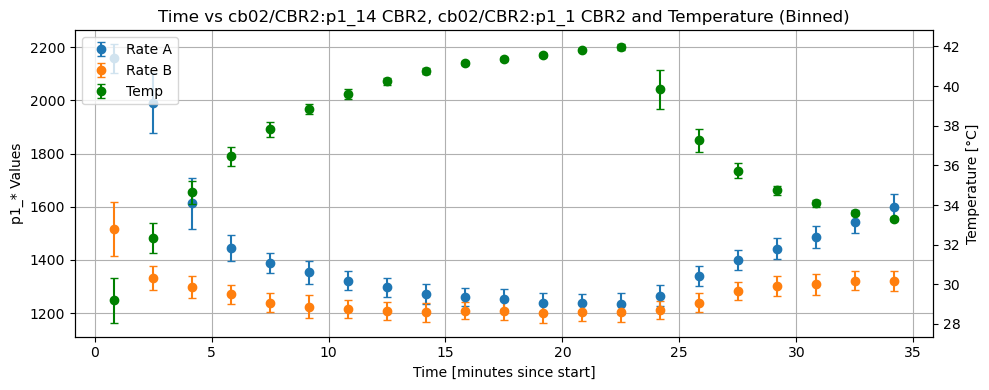

cb02/CBR2:p1_6 CBR2 vs dldb/temp:temp[1]:  ρ=-0.981, p=6.84e-15
cb02/CBR2:p1_7 CBR2 vs dldb/temp:temp[1]:  ρ=-0.981, p=6.84e-15


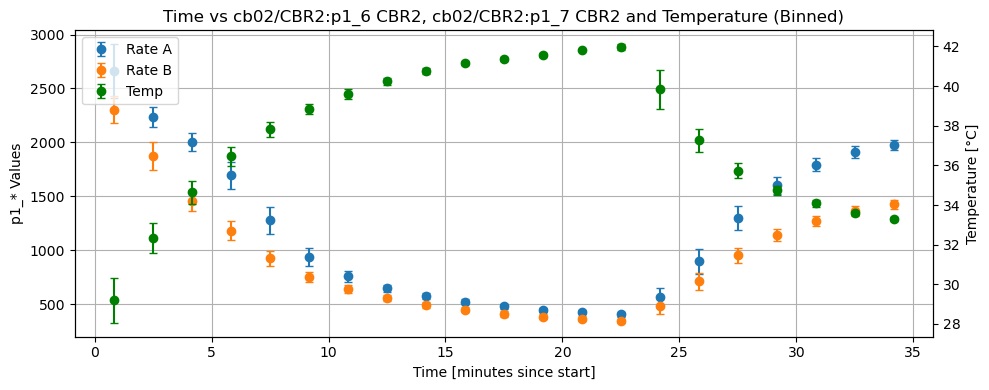

cb02/CBR2:p1_10 CBR2 vs dldb/temp:temp[1]:  ρ=-0.997, p=3.55e-23
cb02/CBR2:p1_11 CBR2 vs dldb/temp:temp[1]:  ρ=-0.997, p=3.55e-23


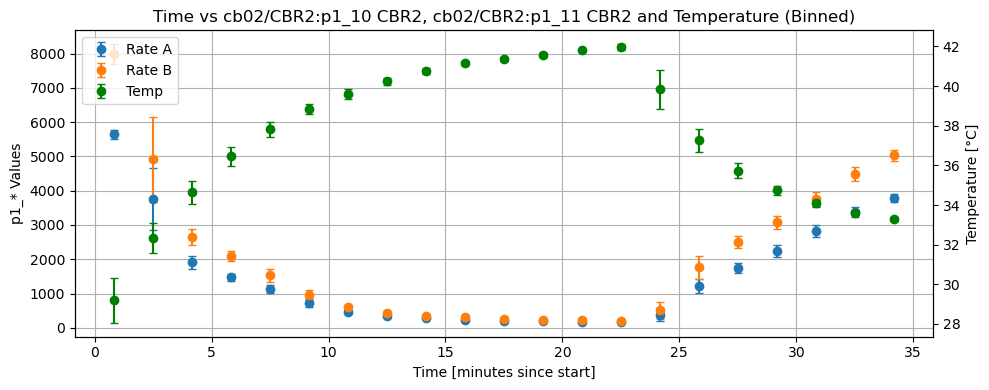

cb02/CBR2:p1_0 CBR2 vs dldb/temp:temp[1]:  ρ=-0.995, p=2.55e-20
cb02/CBR2:p1_15 CBR2 vs dldb/temp:temp[1]:  ρ=-0.981, p=6.84e-15


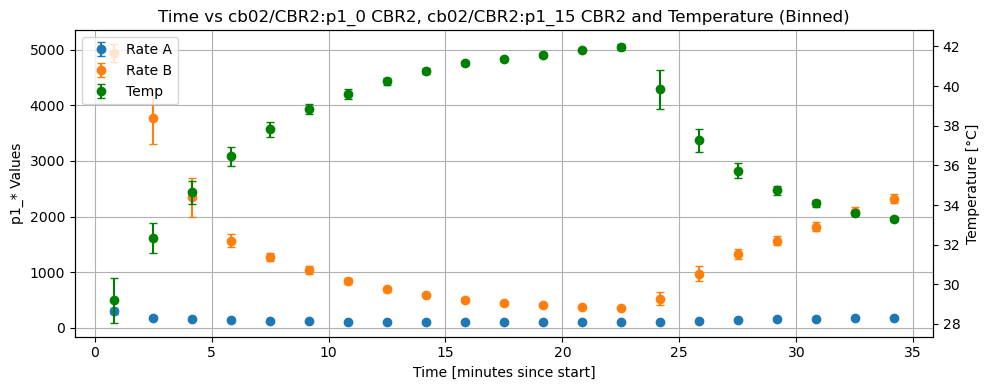

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ==== Parameters ====
bin_width = 100
third_csv = "DL_RATESA_08_07.csv"  # change to your filename
temp_csv = "DL_TEMP_08_07.csv"    # temperature data file
temp_col = "dldb/temp:temp[1]"   # which temp to plot
outlier_threshold = 1e4    # cap for p1_* values

# ==== Load Third Dataset ====
third_df = pd.read_csv(third_csv, sep=",")
third_df.columns = third_df.columns.str.strip()
time_third = third_df["Time"].to_numpy()
time_minutes = (time_third - time_third[0]) / 60

# ==== Load Temperature Dataset ====
temp_df = pd.read_csv(temp_csv, sep=",")
temp_df.columns = temp_df.columns.str.strip()
time_temp = temp_df["Time"].to_numpy()
temp_vals = temp_df[temp_col].to_numpy()

# ==== Match lengths (truncate to shortest) ====
n_points = min(len(time_third), len(time_temp))
time_third = time_third[:n_points]
time_minutes = time_minutes[:n_points]
temp_vals = temp_vals[:n_points]
third_df = third_df.iloc[:n_points]

# ==== Column name pairs ====
col_pairs = [
    ("cb02/CBR2:p1_14 CBR2", "cb02/CBR2:p1_1 CBR2"),
    ("cb02/CBR2:p1_6 CBR2", "cb02/CBR2:p1_7 CBR2"),
    ("cb02/CBR2:p1_10 CBR2", "cb02/CBR2:p1_11 CBR2"),
    ("cb02/CBR2:p1_0 CBR2", "cb02/CBR2:p1_15 CBR2"),
]

# ==== Bin setup ====
n_bins = n_points // bin_width
trimmed_len = n_bins * bin_width
time_binned = time_minutes[:trimmed_len].reshape(n_bins, bin_width)
temp_binned = temp_vals[:trimmed_len].reshape(n_bins, bin_width)
temp_avg = temp_binned.mean(axis=1)
temp_std = temp_binned.std(axis=1)

# ==== Plot each pair ====
for col1, col2 in col_pairs:
    data1 = third_df[col1].to_numpy()
    data2 = third_df[col2].to_numpy()

    # Apply outlier mask for both cols
    mask = (data1 <= outlier_threshold) & (data2 <= outlier_threshold)
    time_clean = time_minutes[mask]
    data1_clean = data1[mask]
    data2_clean = data2[mask]
    temp_clean = temp_vals[mask]

    # Adjust binning after outlier removal
    n_points_clean = len(time_clean)
    n_bins_clean = n_points_clean // bin_width
    trimmed_len_clean = n_bins_clean * bin_width

    time_binned_c = time_clean[:trimmed_len_clean].reshape(n_bins_clean, bin_width)
    data1_binned = data1_clean[:trimmed_len_clean].reshape(n_bins_clean, bin_width)
    data2_binned = data2_clean[:trimmed_len_clean].reshape(n_bins_clean, bin_width)
    temp_binned_c = temp_clean[:trimmed_len_clean].reshape(n_bins_clean, bin_width)

    time_avg = time_binned_c.mean(axis=1)
    avg1, std1 = data1_binned.mean(axis=1), data1_binned.std(axis=1)
    avg2, std2 = data2_binned.mean(axis=1), data2_binned.std(axis=1)
    temp_avg_c, temp_std_c = temp_binned_c.mean(axis=1), temp_binned_c.std(axis=1)
    # Spearman correlation for each col vs temperature
    rho1, p1 = spearmanr(avg1, temp_avg_c)
    rho2, p2 = spearmanr(avg2, temp_avg_c)
    print(f"{col1} vs {temp_col}:  ρ={rho1:.3f}, p={p1:.3g}")
    print(f"{col2} vs {temp_col}:  ρ={rho2:.3f}, p={p2:.3g}")

    # ==== Plot ====
    fig, ax1 = plt.subplots(figsize=(10, 4))

    l1 = ax1.errorbar(time_avg, avg1, yerr=std1, fmt='o', capsize=3, label= "Rate A")
    l2 = ax1.errorbar(time_avg, avg2, yerr=std2, fmt='o', capsize=3, label= "Rate B")
    ax1.set_xlabel("Time [minutes since start]")
    ax1.set_ylabel("p1_* Values")
    ax1.grid(True)

    ax2 = ax1.twinx()
    l3 = ax2.errorbar(time_avg, temp_avg_c, yerr=temp_std_c, fmt='o', capsize=3,
                      color='green', label="Temp")
    ax2.set_ylabel("Temperature [°C]")

    # Combine legends
    lines = [l1, l2, l3]
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title(f"Time vs {col1}, {col2} and Temperature (Binned)")
    plt.tight_layout()
    plt.show()



In [ ]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(rate_avg, temp_avg)
print(f"Spearman correlation: {rho:.3f}, p={p_value:.3g}")